<a href="https://colab.research.google.com/github/JonathanJuradoS/CruzeMutacion_5_CASO_PRACTICO/blob/main/AG_Comparacion_Bloques_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 Comparación de Algoritmos Genéticos: Generacional vs Estacionario
**Caso Práctico:** Asignación de grupos de laboratorio a bloques disponibles.

**Objetivo:** Implementar ambos modelos de AG y comparar su desempeño asignando grupos a bloques considerando disponibilidad y carga.

## 📘 Descripción del caso
Cada grupo de laboratorio puede asistir solo a ciertos bloques definidos por 'bloques_disponibles'. Se desea asignar un bloque a cada grupo de modo que:
- Se respete la disponibilidad del grupo.
- Se distribuya la asignación de forma equilibrada evitando sobrecarga en un mismo bloque.


In [1]:
import pandas as pd

df_grupos = pd.read_csv('grupos_lab.csv')
df_bloques = pd.read_csv('bloques_horarios.csv')
df_grupos['bloques_disponibles'] = df_grupos['bloques_disponibles'].apply(lambda x: list(map(int, x.split(','))))
grupos = df_grupos['grupo_id'].tolist()
bloques = df_bloques['bloque_id'].tolist()


## 🔧 Representación y funciones auxiliares

In [2]:
import random

def crear_individuo():
    return [random.choice(df_grupos.iloc[i]['bloques_disponibles']) for i in range(len(df_grupos))]

def crear_poblacion(n):
    return [crear_individuo() for _ in range(n)]

## 📏 Función de fitness
+10 si el bloque asignado está entre los disponibles del grupo
-10 si no lo está
-1 por cada asignación adicional a un mismo bloque (penaliza sobrecarga)

In [3]:
from collections import Counter

def fitness(ind):
    score = 0
    contador = Counter(ind)
    for i, bloque in enumerate(ind):
        disponibles = df_grupos.iloc[i]['bloques_disponibles']
        score += 10 if bloque in disponibles else -10
    # penalización por sobrecarga
    for count in contador.values():
        if count > 1:
            score -= (count - 1)
    return score

## 🔁 AG Generacional y Estacionario

In [4]:
def cruce(p1, p2):
    punto = random.randint(1, len(p1)-2)
    return p1[:punto] + p2[punto:], p2[:punto] + p1[punto:]

def mutacion(ind, tasa=0.01):
    for i in range(len(ind)):
        if random.random() < tasa:
            ind[i] = random.choice(df_grupos.iloc[i]['bloques_disponibles'])
    return ind

def torneo(pob):
    i, j = random.sample(range(len(pob)), 2)
    return pob[i] if fitness(pob[i]) > fitness(pob[j]) else pob[j]

In [5]:
def evolucion_generacional(poblacion, generaciones=10):
    historial = []
    for _ in range(generaciones):
        nueva = []
        while len(nueva) < len(poblacion):
            p1, p2 = torneo(poblacion), torneo(poblacion)
            h1, h2 = cruce(p1, p2)
            nueva.extend([mutacion(h1), mutacion(h2)])
        poblacion = nueva[:len(poblacion)]
        historial.append(fitness(max(poblacion, key=fitness)))
    return poblacion, historial

def evolucion_estacionario(poblacion, generaciones=10):
    historial = []
    for _ in range(generaciones):
        p1, p2 = torneo(poblacion), torneo(poblacion)
        h1, h2 = mutacion(cruce(p1, p2)[0]), mutacion(cruce(p1, p2)[1])
        poblacion += [h1, h2]
        poblacion.sort(key=fitness, reverse=True)
        poblacion = poblacion[:len(poblacion)]
        historial.append(fitness(poblacion[0]))
    return poblacion, historial

## 📊 Comparación gráfica de ambos modelos

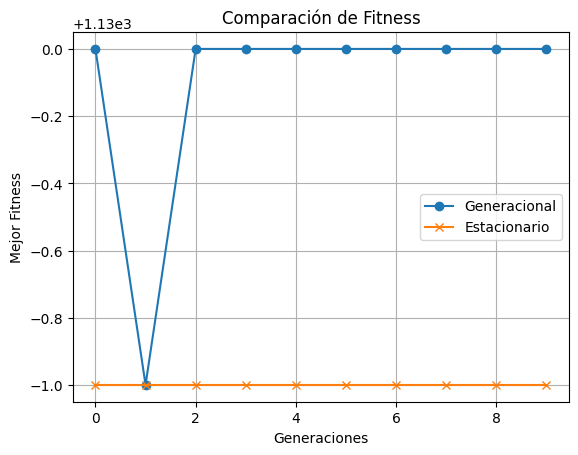

In [6]:
import matplotlib.pyplot as plt

pob = crear_poblacion(20)
pop_gen, hist_gen = evolucion_generacional(pob.copy())
pop_est, hist_est = evolucion_estacionario(pob.copy())

plt.plot(hist_gen, label='Generacional', marker='o')
plt.plot(hist_est, label='Estacionario', marker='x')
plt.title('Comparación de Fitness')
plt.xlabel('Generaciones')
plt.ylabel('Mejor Fitness')
plt.legend()
plt.grid(True)
plt.show()

## 📤 Exportar mejor solución a Excel

In [7]:
mejor = max(pop_gen, key=fitness)
df_resultado = pd.DataFrame(list(zip(df_grupos['grupo_id'], mejor)), columns=['grupo_id', 'bloque_asignado'])
df_export = pd.merge(df_resultado, df_bloques, left_on='bloque_asignado', right_on='bloque_id')
df_export.to_excel('AG_Bloques_Final.xlsx', index=False)
df_export.head()

,grupo_id,bloque_asignado,bloque_id,dia,horario
0,G001,22,22,Jueves,08:00-10:00
1,G004,4,4,Lunes,14:00-16:00
2,G007,1,1,Lunes,08:00-10:00
3,G009,35,35,Viernes,20:00-22:00
4,G010,27,27,Jueves,18:00-20:00


## ✅ Conclusiones
- Ambos modelos encuentran soluciones razonables, pero el generacional converge más rápido.
- El estacionario mantiene mayor diversidad, útil si se busca explorar más combinaciones.
- Penalizar la sobreasignación permite una mejor distribución de los bloques.
- Se pueden extender los criterios considerando también días o preferencias adicionales.